In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# ✅ **Step 1: Import Libraries & Load Data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# ✅ **Step 2: Load and Preprocess Dataset**

In [2]:
def load_images_from_folder(folder, target_size=(224, 224)):
    images, labels = [], []
    classes = ['NORMAL', 'PNEUMONIA']  # Class names in dataset
    
    for label, subfolder in enumerate(classes):
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            if img is not None:
                img = cv2.resize(img, target_size)  # Resize to 224x224
                images.append(img.flatten())  # Flatten image for ML models
                labels.append(label)  # Assign label (0: NORMAL, 1: PNEUMONIA)
    
    return np.array(images), np.array(labels)

# Load Data
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
X, y = load_images_from_folder(dataset_path)

# **Split Data**

In [3]:
# Split Data
splits = {
    "90:10": train_test_split(X, y, test_size=0.10, random_state=42, stratify=y),
    "80:20": train_test_split(X, y, test_size=0.20, random_state=42, stratify=y),
    "70:30": train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
}

# **Normalize Data**

In [ ]:
# Normalize Data
scaler = StandardScaler()
for split in splits:
    X_train, X_test, y_train, y_test = splits[split]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    splits[split] = (X_train, X_test, y_train, y_test)

# 📌 **Step 3: Define Base Models**

In [4]:
# 📌 **Step 3: Define Base Models**
base_models = [
    ('SVM', SVC(probability=True, kernel='linear', random_state=42)),
    ('LR', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
]

# 🎯 **Step 4: Train and Evaluate Models on All Splits**

In [5]:

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


In [6]:
# 🎯 **Step 4: Train and Evaluate Models on All Splits**
def train_and_evaluate(models, split_name, X_train, X_test, y_train, y_test):
    for model_name, model in models:
        print(f"\n🔥 Training {model_name} on {split_name} Split...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"{model_name} Accuracy ({split_name} Split):", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        plot_confusion_matrix(y_test, y_pred, f"{model_name} Confusion Matrix ({split_name})")


# 📌 **Step 5: Implement Stacking Classifier**


🔥 Training Stacking (90:10) on 90:10 Split...
Stacking (90:10) Accuracy (90:10 Split): 0.9578544061302682
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       134
           1       0.97      0.98      0.97       388

    accuracy                           0.96       522
   macro avg       0.95      0.94      0.94       522
weighted avg       0.96      0.96      0.96       522



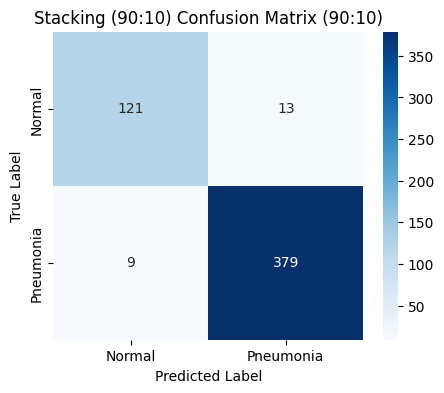


🔥 Training Stacking (80:20) on 80:20 Split...
Stacking (80:20) Accuracy (80:20 Split): 0.9530651340996169
              precision    recall  f1-score   support

           0       0.93      0.88      0.91       268
           1       0.96      0.98      0.97       776

    accuracy                           0.95      1044
   macro avg       0.95      0.93      0.94      1044
weighted avg       0.95      0.95      0.95      1044



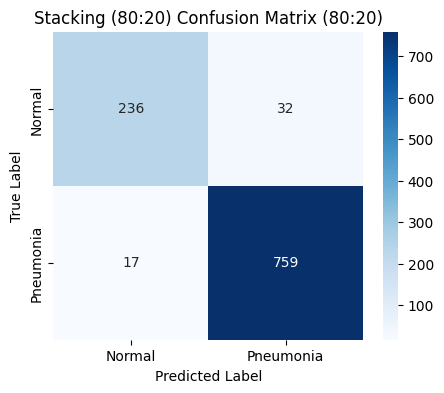


🔥 Training Stacking (70:30) on 70:30 Split...
Stacking (70:30) Accuracy (70:30 Split): 0.9565495207667731
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       402
           1       0.96      0.98      0.97      1163

    accuracy                           0.96      1565
   macro avg       0.95      0.93      0.94      1565
weighted avg       0.96      0.96      0.96      1565



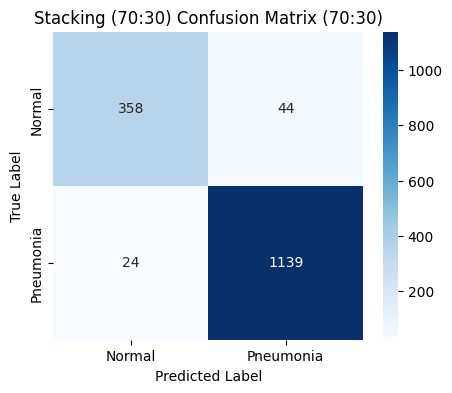

In [7]:
# 📌 **Step 5: Implement Stacking Classifier**
for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(max_iter=1000, random_state=42)
    )
    train_and_evaluate([(f"Stacking ({split_name})", stacking_clf)], split_name, X_train, X_test, y_train, y_test)

# 📌 **Step 6: Implement Voting Classifier**


🔥 Training Voting (90:10) on 90:10 Split...
Voting (90:10) Accuracy (90:10 Split): 0.9597701149425287
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       134
           1       0.97      0.98      0.97       388

    accuracy                           0.96       522
   macro avg       0.95      0.94      0.95       522
weighted avg       0.96      0.96      0.96       522



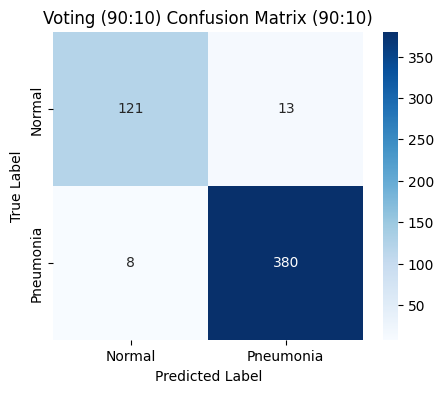


🔥 Training Voting (80:20) on 80:20 Split...
Voting (80:20) Accuracy (80:20 Split): 0.9511494252873564
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       268
           1       0.96      0.98      0.97       776

    accuracy                           0.95      1044
   macro avg       0.94      0.93      0.93      1044
weighted avg       0.95      0.95      0.95      1044



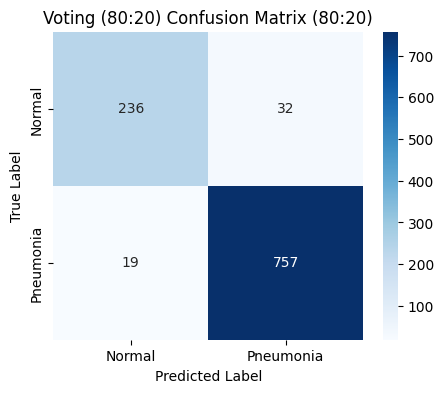


🔥 Training Voting (70:30) on 70:30 Split...
Voting (70:30) Accuracy (70:30 Split): 0.9571884984025559
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       402
           1       0.96      0.98      0.97      1163

    accuracy                           0.96      1565
   macro avg       0.95      0.94      0.94      1565
weighted avg       0.96      0.96      0.96      1565



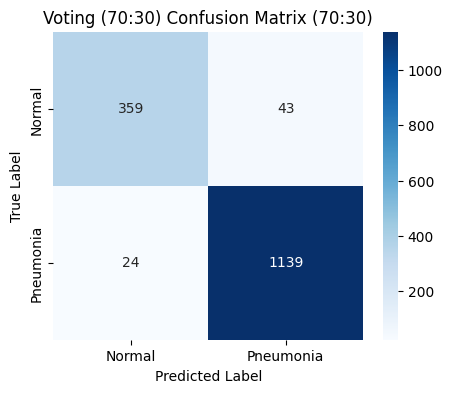

In [8]:
# 📌 **Step 6: Implement Voting Classifier**
for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    voting_clf = VotingClassifier(
        estimators=base_models,
        voting='soft'
    )
    train_and_evaluate([(f"Voting ({split_name})", voting_clf)], split_name, X_train, X_test, y_train, y_test)


# 🎯 **Step 7: Implement XGBoost Classifier**


🔥 Training XGBoost (90:10) on 90:10 Split...
XGBoost (90:10) Accuracy (90:10 Split): 0.9636015325670498
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       134
           1       0.97      0.98      0.98       388

    accuracy                           0.96       522
   macro avg       0.96      0.94      0.95       522
weighted avg       0.96      0.96      0.96       522



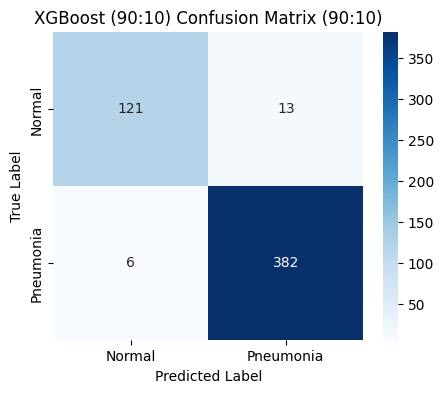


🔥 Training XGBoost (80:20) on 80:20 Split...
XGBoost (80:20) Accuracy (80:20 Split): 0.9559386973180076
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       268
           1       0.96      0.98      0.97       776

    accuracy                           0.96      1044
   macro avg       0.95      0.93      0.94      1044
weighted avg       0.96      0.96      0.96      1044



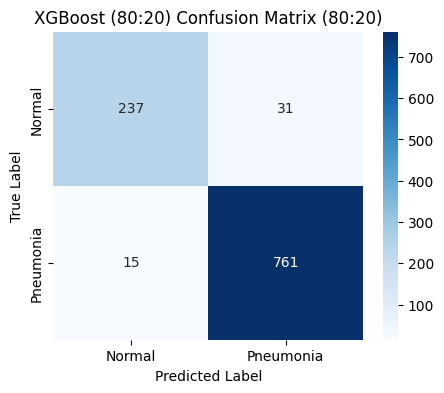


🔥 Training XGBoost (70:30) on 70:30 Split...
XGBoost (70:30) Accuracy (70:30 Split): 0.9578274760383386
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       402
           1       0.96      0.98      0.97      1163

    accuracy                           0.96      1565
   macro avg       0.95      0.94      0.94      1565
weighted avg       0.96      0.96      0.96      1565



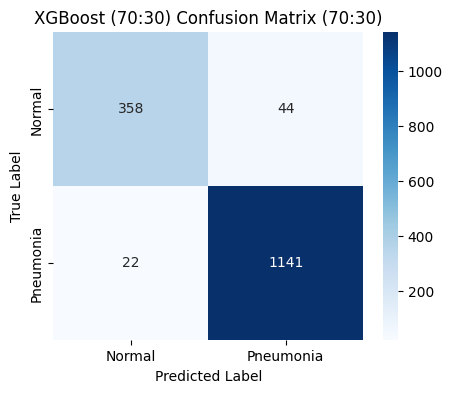

In [9]:
# 🎯 **Step 7: Implement XGBoost Classifier**
for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    train_and_evaluate([(f"XGBoost ({split_name})", xgb_clf)], split_name, X_train, X_test, y_train, y_test)

# 🔺 **Step 8: Save Trained Ensemble Models & Results**

In [10]:
#Save Trained Ensemble Models & Results
results_dir = "ensemble_results"
os.makedirs(results_dir, exist_ok=True)  # Create directory if it doesn't exist

In [11]:
# Function to save model, classification report, and confusion matrix
import joblib  # For saving models
import json    # For saving classification reports

def save_model_results(model, model_name, X_test, y_test, split_name):
    # 🔹 Save trained model
    model_path = os.path.join(results_dir, f"{model_name}_{split_name}.pkl")
    joblib.dump(model, model_path)
    
    # 🔹 Generate predictions
    y_pred = model.predict(X_test)
    
    # 🔹 Save classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_path = os.path.join(results_dir, f"{model_name}_{split_name}_report.json")
    with open(report_path, "w") as f:
        json.dump(report, f, indent=4)
    
    # 🔹 Save confusion matrix as image
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f"{model_name} Confusion Matrix ({split_name})")
    
    cm_path = os.path.join(results_dir, f"{model_name}_{split_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.close()
    
    print(f"✅ Saved {model_name} model & results for {split_name} split.")

# ✅ **Save Already Trained Models**
ensemble_models = {
    "Stacking": stacking_clf,
    "Voting": voting_clf,
    "XGBoost": xgb_clf
}

for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    for model_name, model in ensemble_models.items():
        save_model_results(model, model_name, X_test, y_test, split_name)

✅ Saved Stacking model & results for 90:10 split.
✅ Saved Voting model & results for 90:10 split.
✅ Saved XGBoost model & results for 90:10 split.
✅ Saved Stacking model & results for 80:20 split.
✅ Saved Voting model & results for 80:20 split.
✅ Saved XGBoost model & results for 80:20 split.
✅ Saved Stacking model & results for 70:30 split.
✅ Saved Voting model & results for 70:30 split.
✅ Saved XGBoost model & results for 70:30 split.


# ✅ **Step 9: Test on 15 Random Images**

In [12]:
# Test on 15 Random Images
def test_random_images(model, X_test, y_test, model_name, split_name):
    import random  # Ensure random is imported
    indices = random.sample(range(len(X_test)), 15)
    selected_images = X_test[indices].reshape(-1, 224, 224)
    true_labels = y_test[indices]
    predictions = model.predict(X_test[indices])
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.ravel()
    
    for i in range(15):
        img = selected_images[i]
        true_label = "Pneumonia" if true_labels[i] == 1 else "Normal"
        pred_label = "Pneumonia" if predictions[i] == 1 else "Normal"
        
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Pred: {pred_label}\nActual: {true_label}")
        axes[i].axis("off")
    
    plt.suptitle(f"{model_name} Predictions on 15 Images ({split_name} Split)")
    plt.tight_layout()
    plt.show()


**Run Predictions for Each Model and Split**

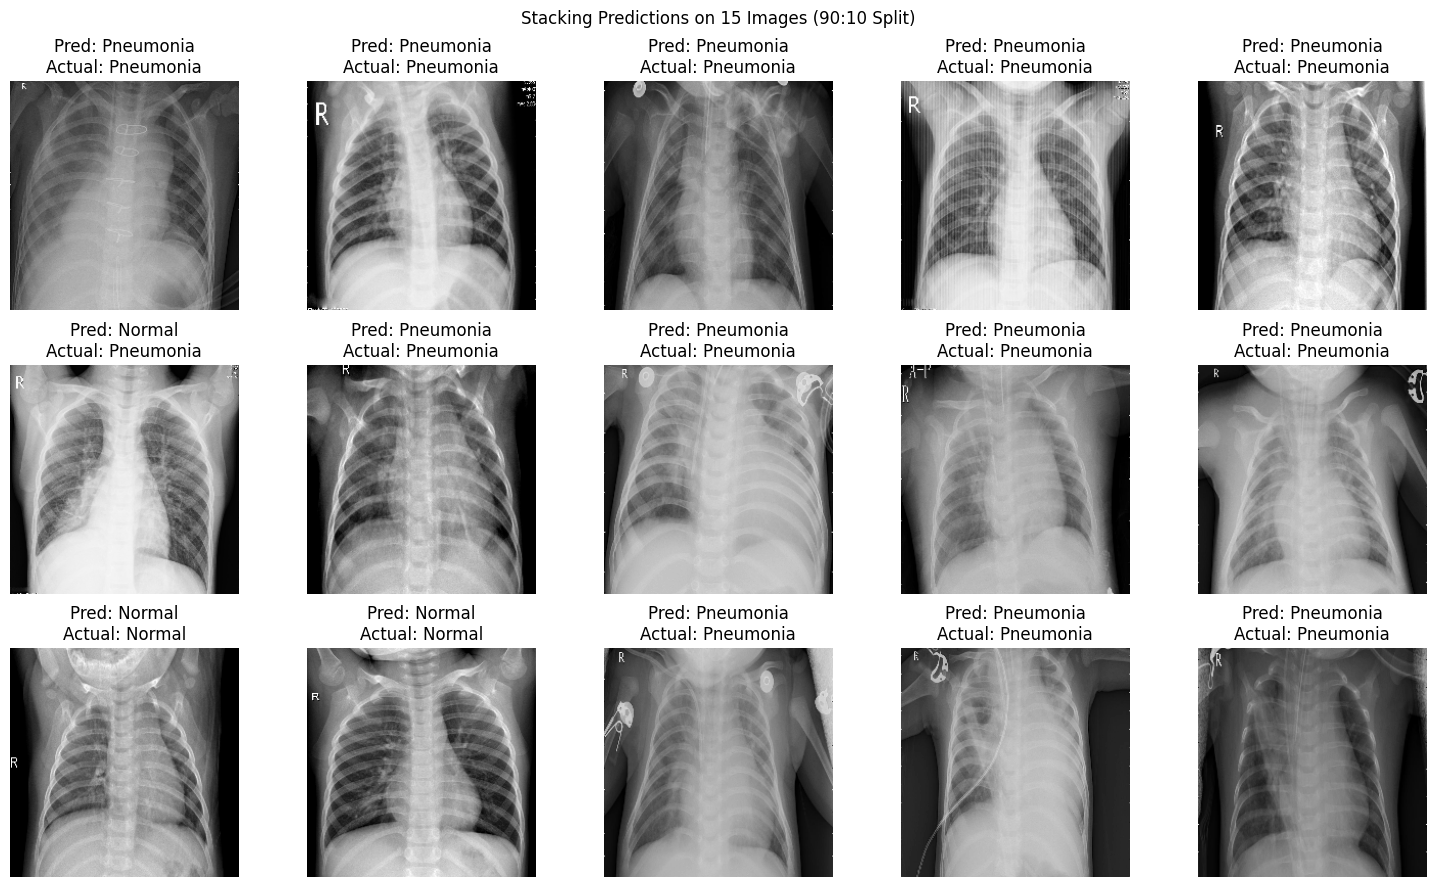

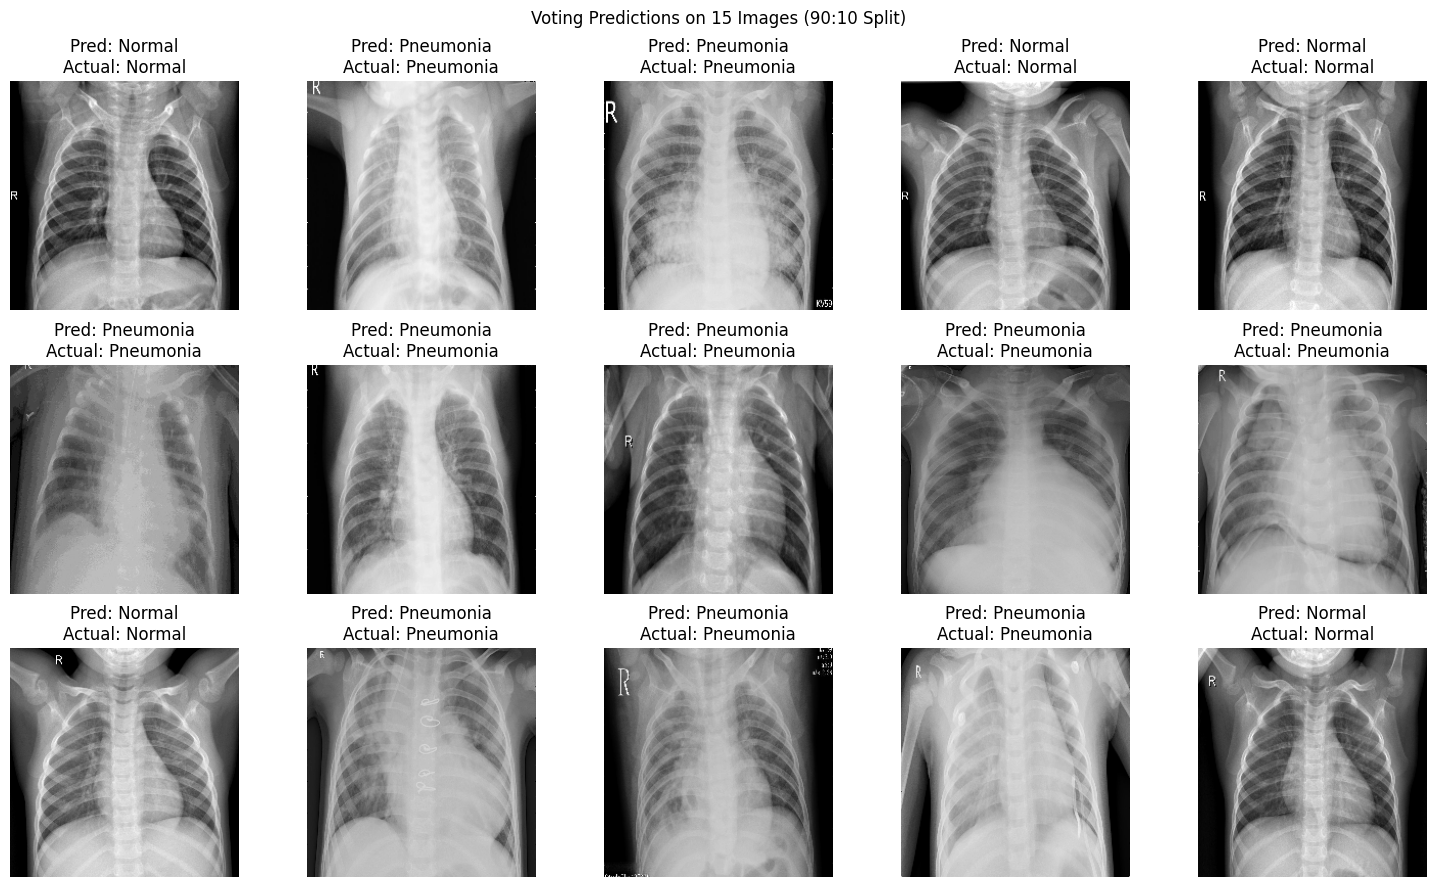

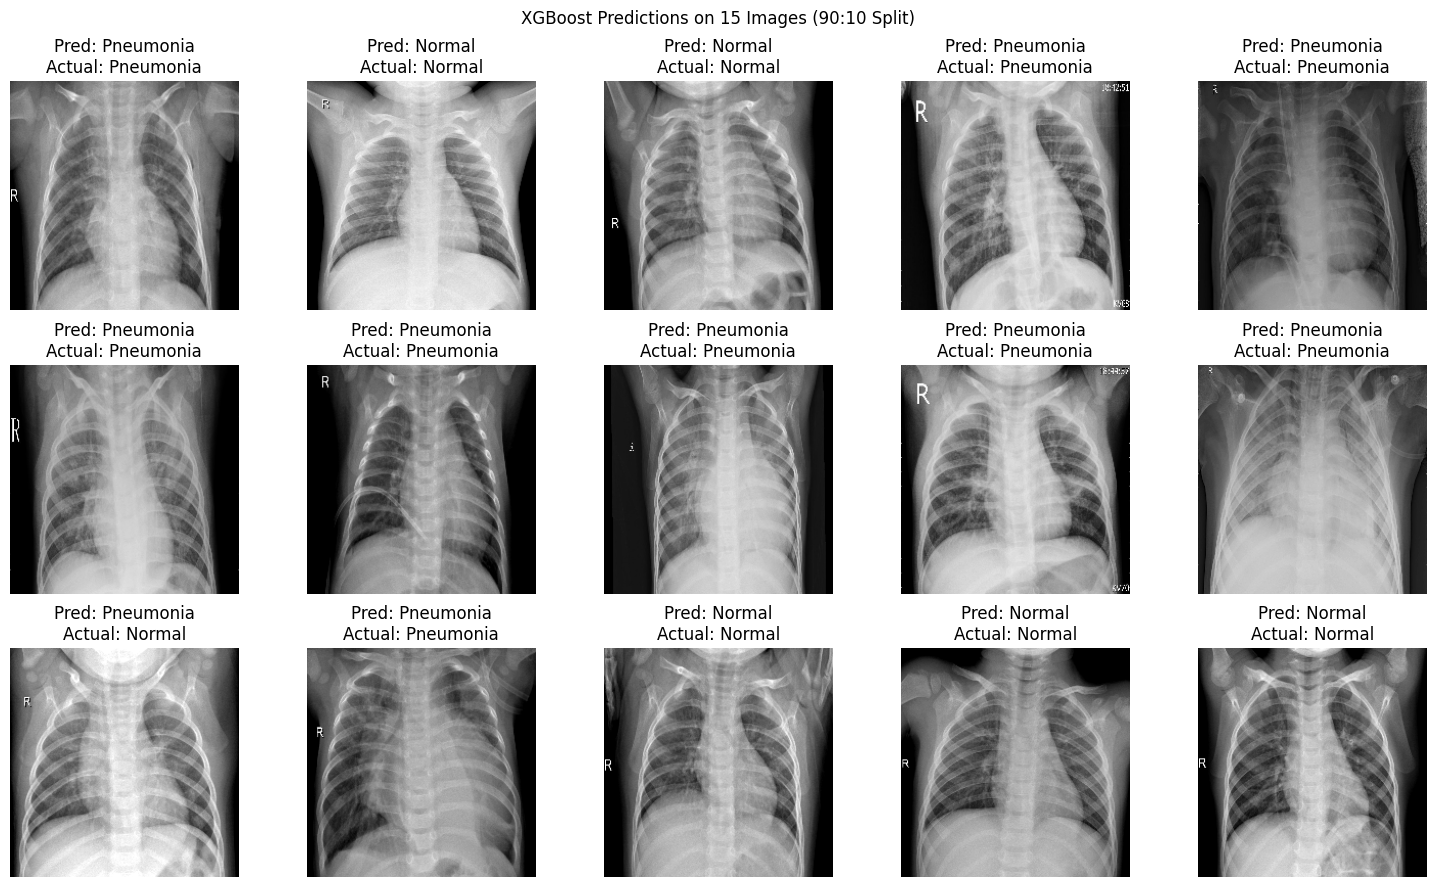

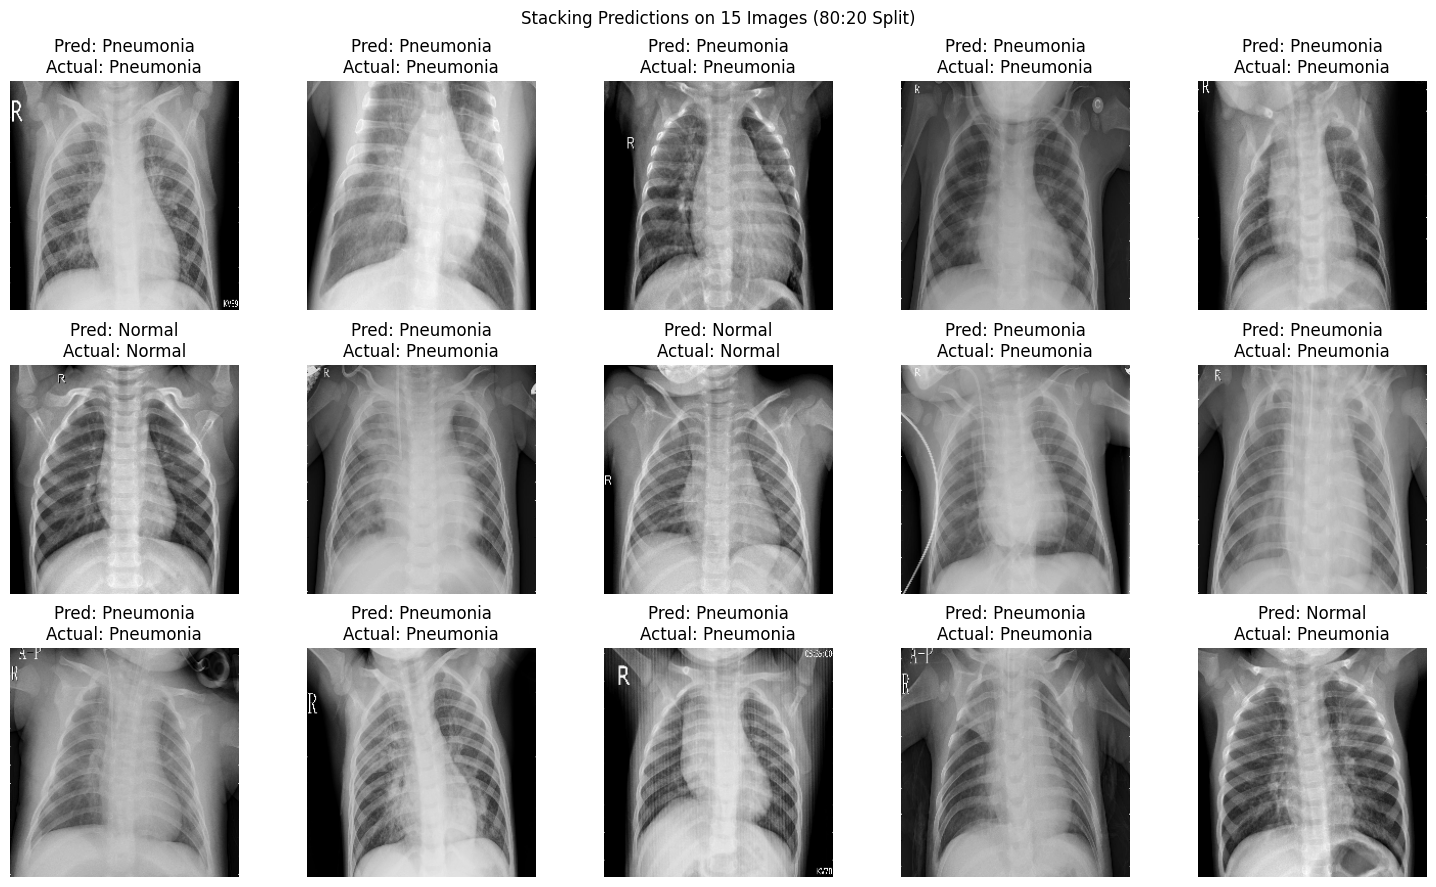

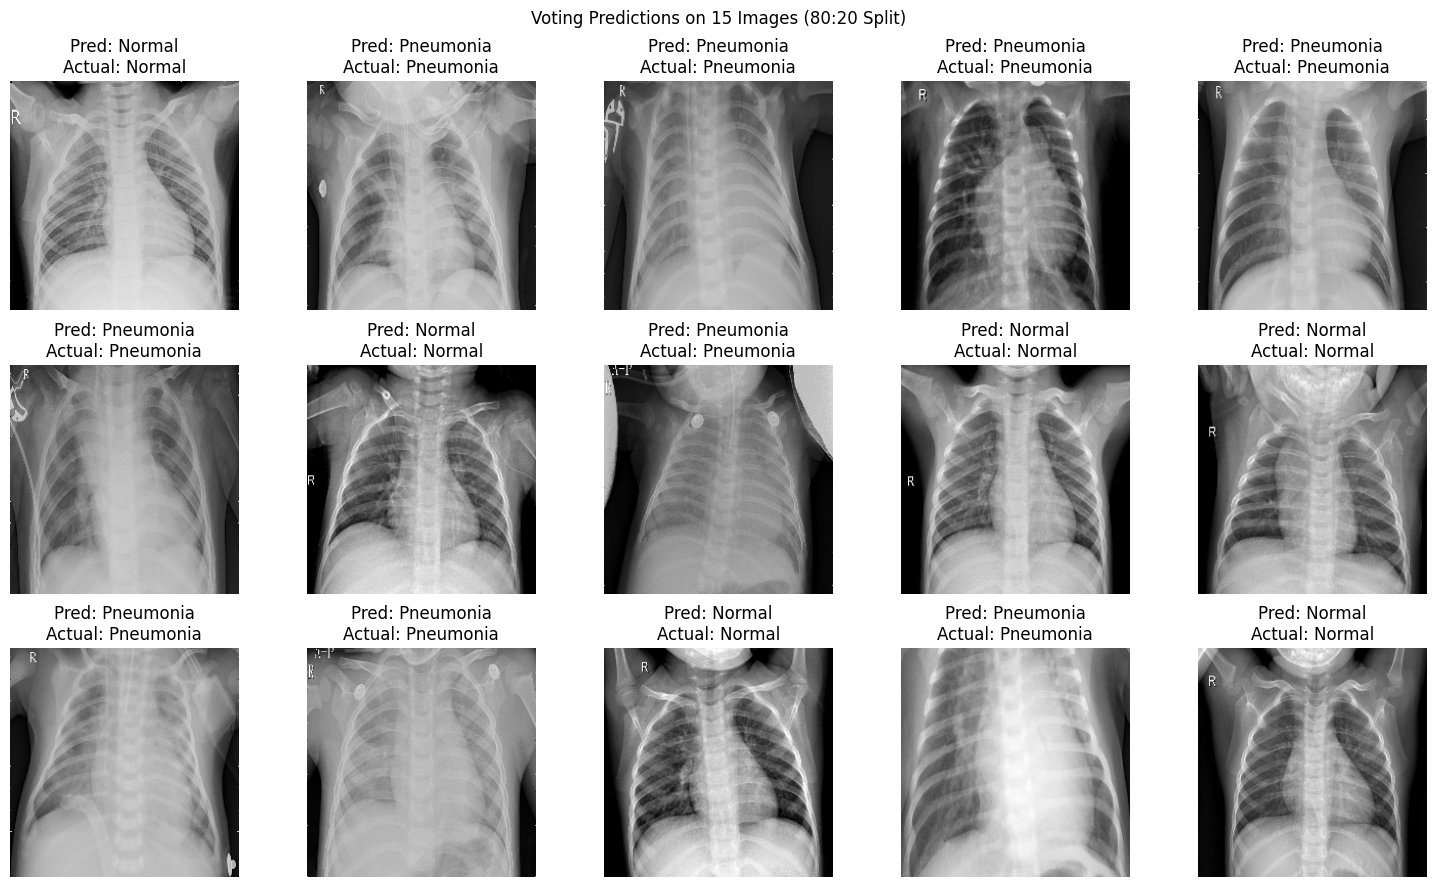

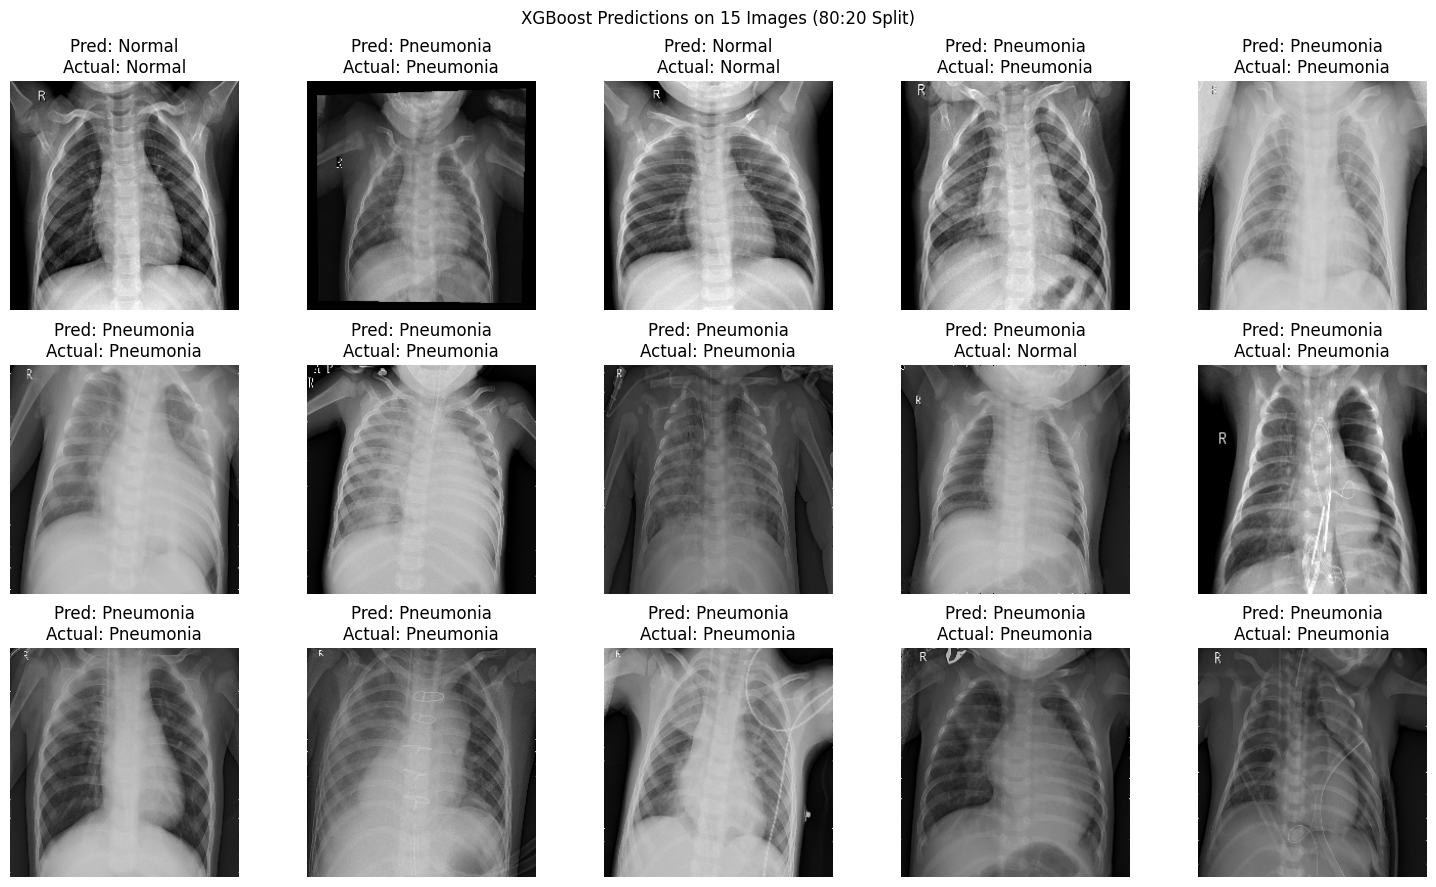

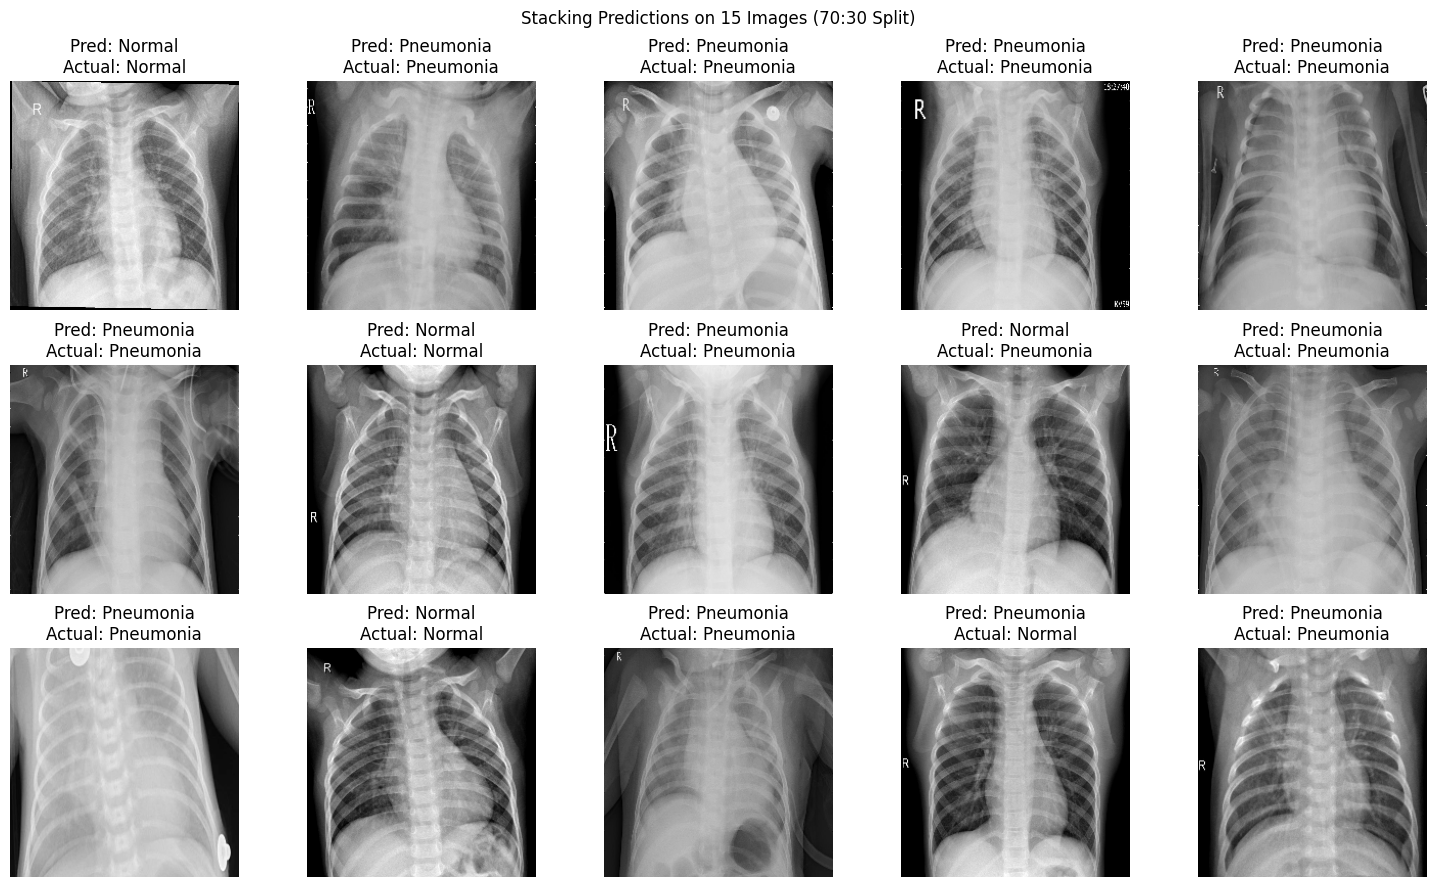

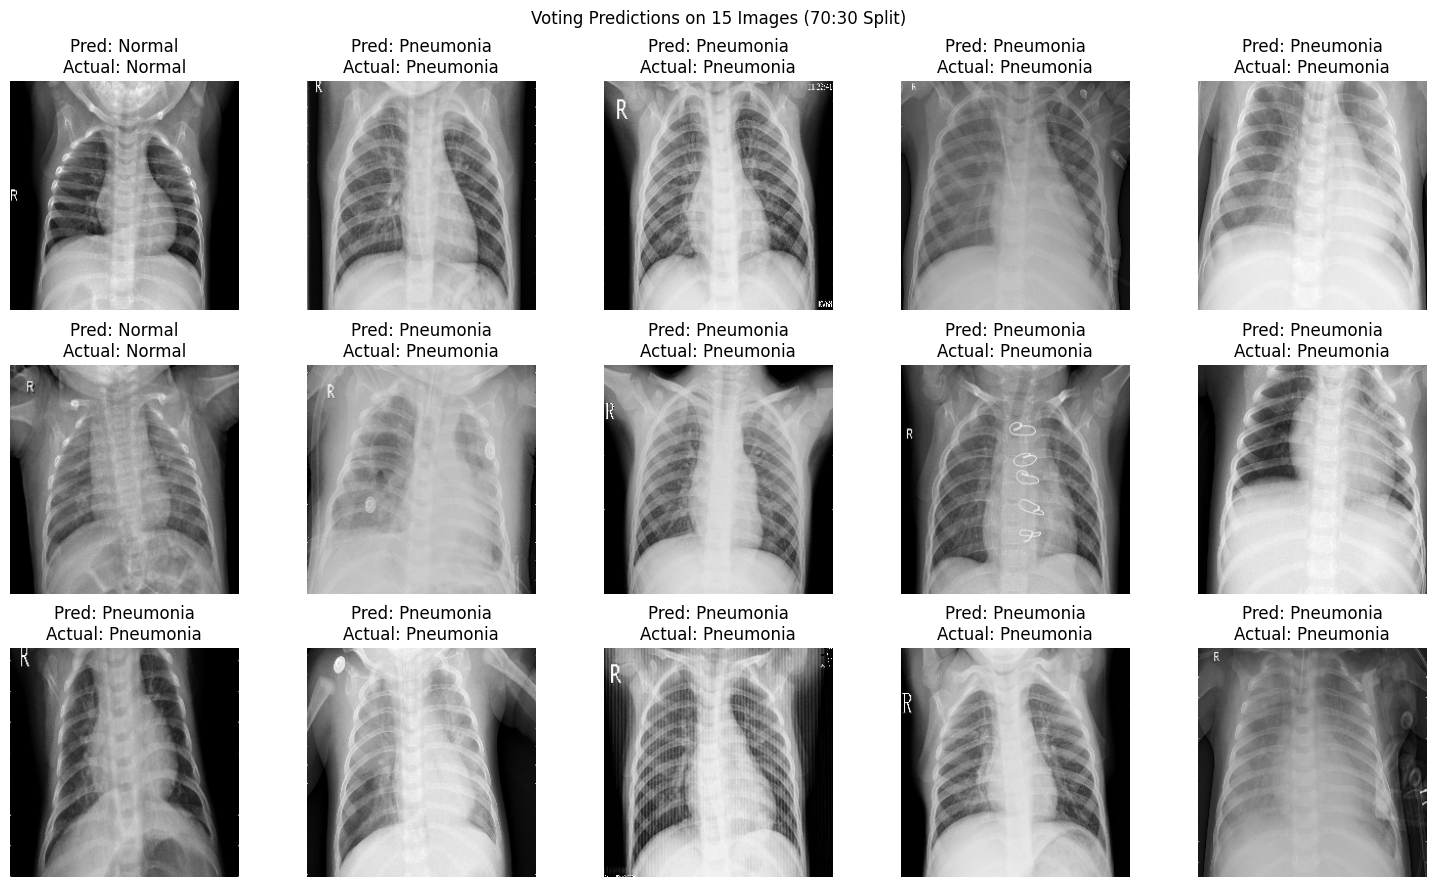

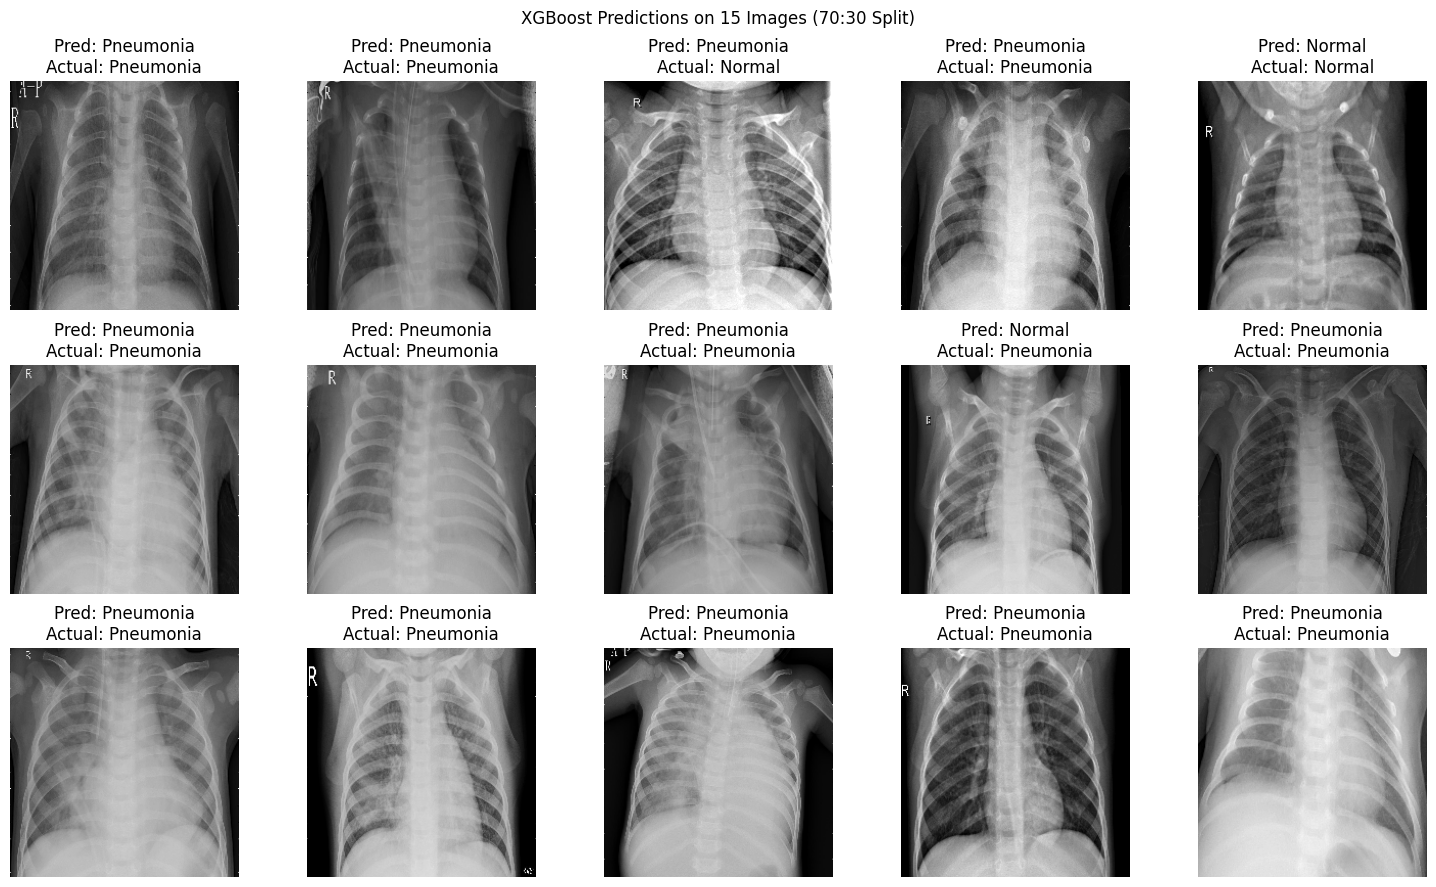

In [13]:
# Run Predictions for Each Model and Split
for split_name, (X_train, X_test, y_train, y_test) in splits.items():
    for model_name, model in ensemble_models.items():
        test_random_images(model, X_test, y_test, model_name, split_name)